In [ ]:
#------------------------------Keras Packages----------------------------------- 
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.densenet import DenseNet201, DenseNet121
from keras.preprocessing.image import ImageDataGenerator


#------------------------------Others python Packages---------------------------
import numpy as np # High-level mathematical functions for n-dimensional arrays 
import os   
import cv2
from google.colab.patches import cv2_imshow
import glob
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from skimage.measure import label, regionprops
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import jaccard_similarity_score

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import zipfile
dataset_path = '/gdrive/MyDrive/ISIC_2017/ISIC-2017_Training_Part1_GroundTruth.zip'
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

In [ ]:
import zipfile
dataset_path = '/gdrive/MyDrive/ISIC_2017/ISIC-2017_Training_Data.zip'
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

In [ ]:
data = glob.glob('ISIC-2017_Training_Data/*.jpg')

In [ ]:
%%shell
cd ISIC-2017_Training_Part1_GroundTruth
rename 's/_segmentation//' *
cd ..

In [ ]:
labels = glob.glob('ISIC-2017_Training_Part1_GroundTruth/*.png')

In [ ]:
def show_labels(num_rows,num_columns,data):
  fig = plt.figure(figsize=(10,10))
  gs = fig.add_gridspec(num_columns, num_rows)
  for i in range(num_rows):
    for j in range(num_columns):
      indi = (i*num_columns) + j
      ax = fig.add_subplot(gs[i, j])
      ax.imshow( cv2.imread(labels[indi]))
      ax.axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
  plt.show()

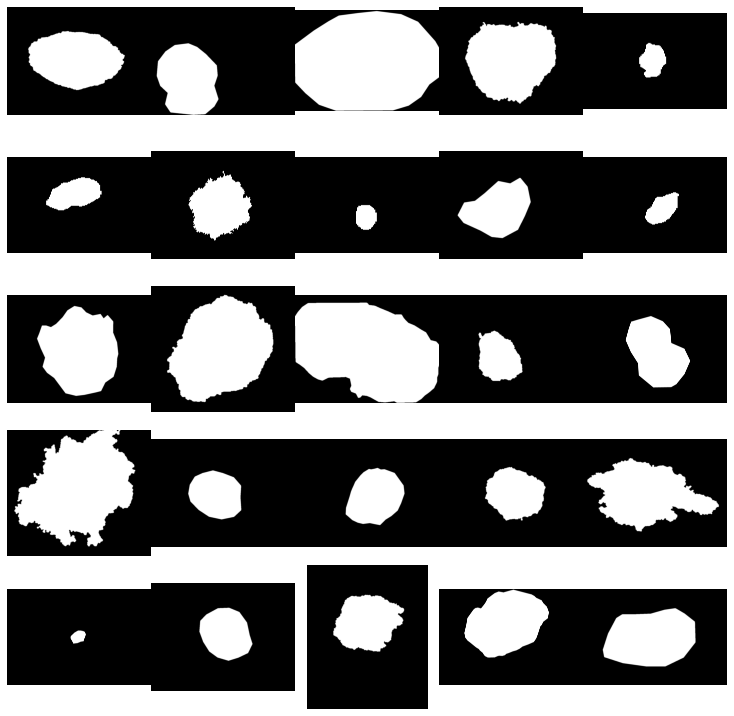

In [ ]:
show_labels(5,5,labels)

In [ ]:
import zipfile
dataset_path = '/gdrive/My Drive/ISIC_2017/ISIC-2017_Validation_Data.zip'
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

In [ ]:
validation_data = glob.glob('ISIC-2017_Validation_Data/*.jpg')

In [ ]:
import zipfile
dataset_path = '/gdrive/MyDrive/ISIC_2017/ISIC-2017_Validation_Part1_GroundTruth.zip'
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

In [ ]:
%%shell
cd ISIC-2017_Validation_Part1_GroundTruth
rename 's/_segmentation//' *
cd ..

In [ ]:
validation_labels = glob.glob('ISIC-2017_Validation_Part1_GroundTruth/*.png')

In [ ]:
!mkdir train
!mkdir train/images
!mkdir train/images/ISIC-2017_Training_Data
!mkdir train/masks

In [ ]:
!cp -r ISIC-2017_Training_Part1_GroundTruth train/masks

In [ ]:
!mv ISIC-2017_Training_Data/*.jpg train/images/ISIC-2017_Training_Data

In [ ]:
k = glob.glob('train/images/ISIC-2017_Training_Data/*.jpg')
len(k)

2000

In [ ]:
!mkdir validation
!mkdir validation/masks
!mkdir validation/images
!mkdir validation/images/ISIC-2017_Validation_Data

In [ ]:
!cp -r ISIC-2017_Validation_Part1_GroundTruth validation/masks
!mv ISIC-2017_Validation_Data/*.jpg validation/images/ISIC-2017_Validation_Data

In [ ]:
def DSNet(nClasses, input_height, input_width):

    #------------------------------Define Input Shape----------------------------------
    
    img_input = Input(shape=(input_height, input_width, 3)) # defining the Input shape 
    
    #Load DenseNet121 from keras. This model is initialized with the ImageNet. 
    #This part is responsible for the feature extraction which is so called convolution
    # part of the semantic segmentation (Encoder). 
    
    Encoder_Dense = DenseNet121( weights = 'imagenet',
						include_top = False,
						input_tensor = img_input) 

    Encoder = SeparableConv2D(filters = 1024,
					kernel_size = (3, 3),
					activation = 'relu',
					kernel_initializer='he_normal',
					padding="same")(Encoder_Dense.output)
    Encoder = BatchNormalization()(Encoder)

    
    # Decoding the encoded features to reconstruct the original input shape Image.

    Decoder = UpSampling2D(size = (2, 2))(Encoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool3_pool").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 1024,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)
    
    Decoder = UpSampling2D(size = (2, 2))(Decoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool2_pool").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 512,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = UpSampling2D(size = (2, 2))(Decoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool1").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 256,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = UpSampling2D( size = (2, 2))(Decoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="conv1/bn").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 128,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = UpSampling2D(size = (2, 2))(Decoder)    
    Decoder = SeparableConv2D(filters = 64,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = SeparableConv2D(filters = nClasses,
						kernel_size = (1, 1),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)
    

    Predicted_Mask = Conv2D(filters = 1,
									kernel_size = 1,
									activation = 'sigmoid')(Decoder)
    
    
    DSNet_model = Model(inputs = img_input, outputs = Predicted_Mask)

    return DSNet_model

In [ ]:
def DataPreProcessing(img, mask):
    img = preprocess_input(img) # Data standardization meaning 0 mean and unit variance.
    img = img/img.max()         # Data Normalization
    mask = mask/mask.max()      # Mask Normalization
    return (img, mask)      

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth=1e-8
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def Jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def Jaccard_coef_loss(y_true, y_pred):
    return (1-Jaccard_coef(y_true, y_pred))

def bcc_Jaccard_coef_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred)+(1-Jaccard_coef(y_true, y_pred)))

In [ ]:
def Train_Generator(batch_size,train_path,aug_dict,image_color_mode = "rgb",mask_color_mode = "grayscale",target_size = (192,256),seed = 909):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  image_generator = image_datagen.flow_from_directory(train_path+'/images',class_mode = None,color_mode = image_color_mode,target_size = target_size,batch_size = batch_size,seed = seed)
  mask_generator = mask_datagen.flow_from_directory(train_path+'/masks',class_mode = None,color_mode = mask_color_mode,target_size=target_size,batch_size=batch_size,seed=seed)

  t_gen = zip(image_generator,mask_generator)
  for (img,mask) in t_gen:
    img,mask = DataPreProcessing(img,mask)
    yield(img,mask)


In [ ]:
def Validation_Generator(batch_size,val_path,target_size=(192,256),seed=909):
  image_datagen = ImageDataGenerator()
  mask_datagen = ImageDataGenerator()

  image_generator = image_datagen.flow_from_directory(val_path+'/images',color_mode='rgb',class_mode=None,target_size=target_size,batch_size=batch_size,seed=seed)
  mask_generator = mask_datagen.flow_from_directory(val_path+'/masks',color_mode='grayscale',class_mode=None,target_size=target_size,batch_size=batch_size,seed=seed)

  v_gen = zip(image_generator,mask_generator)
  for img,mask in v_gen:
    img,mask = DataPreProcessing(img,mask)
    yield(img,mask)

In [ ]:
data_gen_args = dict(rotation_range=90,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='wrap')
early_stopping = EarlyStopping(monitor='val_Jaccard_coef',
                               patience=5,
                               verbose=1,
                               mode='max',
                               restore_best_weights=True)

height=192
width=256

train_gen = Train_Generator(batch_size=5,train_path='train',aug_dict=data_gen_args)

val_gen = Validation_Generator(batch_size=5,val_path='validation')
opt = tf.keras.optimizers.Adadelta(
  learning_rate=1, rho=0.95) 
model = DSNet(2, height, width)


model.compile(optimizer = opt,
              loss = bcc_Jaccard_coef_loss,
              metrics = [Jaccard_coef,dice_coef,tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.AUC()])


29097984/29084464 [==============================] - 0s 0us/step


In [ ]:



model_checkpoint = ModelCheckpoint('/gdrive/MyDrive/ISIC_2017/Trained_Model_{epoch:03d}-{val_Jaccard_coef:.2f}.hdf5',
                                  verbose=1)                                   

reduce_lr = ReduceLROnPlateau(monitor='val_Jaccard_coef',
                            factor=0.4,
                            patience=8,
                            verbose=1,
                            mode='max',
                            min_lr=0.00000001)
with tf.device('/device:GPU:0'):

  history=model.fit_generator(train_gen, 
                            steps_per_epoch=400, 
                            epochs=35, 
                            verbose=1, 
                            validation_data= val_gen, 
                            validation_steps=30, 
                            callbacks=[model_checkpoint, reduce_lr])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['Jaccard_coef'])
plt.plot(history.history['val_Jaccard_coef'])
plt.title('model Jaccard_coef')
plt.ylabel('Jaccard_coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/gdrive/MyDrive/Trained_Model_ 73_0.78.hdf5')

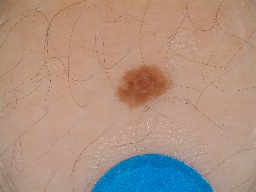

In [ ]:
cv2_imshow(cv2.resize(cv2.imread('validation/images/'+sorted(validation_data)[0]), (256, 192),
               interpolation = cv2.INTER_LINEAR))

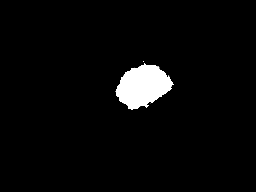

In [ ]:
cv2_imshow(cv2.resize(cv2.imread('validation/masks/'+sorted(validation_labels)[0]), (256, 192),
               interpolation = cv2.INTER_LINEAR))


In [ ]:
from scipy import misc
from sklearn.metrics import roc_curve, auc # roc curve tools

In [ ]:
validation_data = sorted(validation_data)
validation_labels = sorted(validation_labels)

In [ ]:
validation_data[100]

'ISIC-2017_Validation_Data/ISIC_0014211.jpg'

In [ ]:
validation_labels[100]

'ISIC-2017_Validation_Part1_GroundTruth/ISIC_0014211.png'

In [ ]:
len(validation_labels)

150

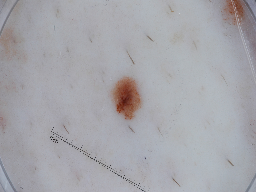

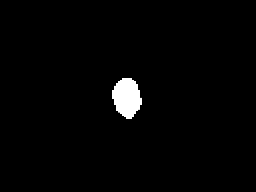

In [ ]:
test_img = cv2.imread('validation/images/'+sorted(validation_data)[45])
test_mask = cv2.imread('validation/masks/'+sorted(validation_labels)[45],cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (256, 192),
               interpolation = cv2.INTER_LINEAR)
test_mask = cv2.resize(test_mask, (256, 192),
               interpolation = cv2.INTER_LINEAR)
cv2_imshow(test_img)
cv2_imshow(test_mask)
test_img = test_img/test_img.max()
test_mask = test_mask/test_mask.max()

In [ ]:
print(test_mask.shape)

(192, 256)


In [ ]:
test_img = test_img.reshape((1,192,256,3))

In [ ]:
y_pred = model.predict(test_img)

In [ ]:
y_pred = y_pred.reshape((192,256))

In [ ]:
y_pred = np.round_(y_pred)
y_pred = y_pred*255


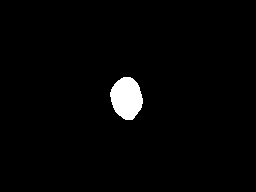

In [ ]:
cv2_imshow(y_pred)

In [ ]:
scores = []
for i in range(5):
  scores.append(model.evaluate(val_gen, verbose = 1,steps=30))

Found 150 images belonging to 1 classes.
Found 150 images belonging to 1 classes.
30/30 [==============================] - 39s 1s/step - loss: 0.4284 - Jaccard_coef: 0.7491 - dice_coef: 0.8483 - true_positives: 4674836.5000 - true_negatives: 27156140.0000 - false_positives: 363572.5000 - false_negatives: 1105925.2500 - auc: 0.9680


In [ ]:
res = np.mean(scores,axis=0)

In [ ]:
res

array([4.21749428e-01, 7.46989429e-01, 8.46822619e-01, 3.13059009e+06,
       1.81195370e+07, 2.45178914e+05, 7.45971852e+05, 9.66917202e-01])

In [ ]:
spec = res[4]/(res[4]+res[5])
sens = res[3]/(res[3]+res[6])

sensitivity=number of true positives/(number of true positives+number of false negatives)

specificity=number of true negatives/(number of true negatives+number of false positives


In [ ]:
print('Sensitivity', sens)
print('Specificity', spec)

Sensitivity 0.8075687008008419
Specificity 0.9866494578402513
